In [1]:
!pip install gensim wget ufal.udpipe

In [2]:
!pip install -U numpy gensim # это чудо решило что оно не запустится без обновы.

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)


In [3]:
import sys
import logging
import gensim
import wget

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Подготовить модель и базу данных (скачать книжку)

In [4]:
udpipe_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
modelfile = wget.download(udpipe_url)

textfile = 'idiot.txt'

In [5]:
!gdown 1OxhEV6_joH4oQrIpVc6QCiTOuSSkCSap

Downloading...
From: https://drive.google.com/uc?id=1OxhEV6_joH4oQrIpVc6QCiTOuSSkCSap
To: /content/idiot.txt
100% 2.36M/2.36M [00:00<00:00, 44.1MB/s]


In [6]:
textfile = 'idiot.txt'

## Функции для леманизации и токенизации текста

In [7]:
def num_replace(word):
    newtoken = 'x' * len(word)
    return newtoken


def clean_token(token, misc):
    out_token = token.strip().replace(' ', '')
    if token == 'Файл' and 'SpaceAfter=No' in misc:
        return None
    return out_token


def clean_lemma(lemma, pos):
    out_lemma = lemma.strip().replace(' ', '').replace('_', '').lower()
    if '|' in out_lemma or out_lemma.endswith('.jpg') or out_lemma.endswith('.png'):
        return None
    if pos != 'PUNCT':
        if out_lemma.startswith('«') or out_lemma.startswith('»'):
            out_lemma = ''.join(out_lemma[1:])
        if out_lemma.endswith('«') or out_lemma.endswith('»'):
            out_lemma = ''.join(out_lemma[:-1])
        if out_lemma.endswith('!') or out_lemma.endswith('?') or out_lemma.endswith(',') \
                or out_lemma.endswith('.'):
            out_lemma = ''.join(out_lemma[:-1])
    return out_lemma

In [8]:
def process(pipeline, text='Строка', keep_pos=True, keep_punct=False):
    entities = {'PROPN'}
    named = False
    memory = []
    mem_case = None
    mem_number = None
    tagged_propn = []

    # обрабатываем текст, получаем результат в формате conllu:
    processed = pipeline.process(text)

    # пропускаем строки со служебной информацией:
    content = [l for l in processed.split('\n') if not l.startswith('#')]

    # извлекаем из обработанного текста леммы, тэги и морфологические характеристики
    tagged = [w.split('\t') for w in content if w]

    for t in tagged:
        if len(t) != 10:
            continue

        (word_id, token, lemma, pos, xpos, feats, head, deprel, deps, misc) = t
        token = clean_token(token, misc)
        lemma = clean_lemma(lemma, pos)
        if not lemma or not token:
            continue

        if pos in entities:
            if '|' not in feats:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            morph = {el.split('=')[0]: el.split('=')[1] for el in feats.split('|')}
            if 'Case' not in morph or 'Number' not in morph:
                tagged_propn.append('%s_%s' % (lemma, pos))
                continue
            if not named:
                named = True
                mem_case = morph['Case']
                mem_number = morph['Number']
            if morph['Case'] == mem_case and morph['Number'] == mem_number:
                memory.append(lemma)
                if 'SpacesAfter=\\n' in misc or 'SpacesAfter=\s\\n' in misc:
                    named = False
                    past_lemma = '::'.join(memory)
                    memory = []
                    tagged_propn.append(past_lemma + '_PROPN ')
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))
        else:
            if not named:
                if pos == 'NUM' and token.isdigit():  # Заменяем числа на xxxxx той же длины
                    lemma = num_replace(token)
                tagged_propn.append('%s_%s' % (lemma, pos))
            else:
                named = False
                past_lemma = '::'.join(memory)
                memory = []
                tagged_propn.append(past_lemma + '_PROPN ')
                tagged_propn.append('%s_%s' % (lemma, pos))

    if not keep_punct:
        tagged_propn = [word for word in tagged_propn if word.split('_')[1] != 'PUNCT']
    if not keep_pos:
        tagged_propn = [word.split('_')[0] for word in tagged_propn]
    return tagged_propn

In [9]:
from ufal.udpipe import Model, Pipeline
import os
import re
import sys

def tag_ud(text='Текст нужно передать функции в виде строки!', modelfile='udpipe_syntagrus.model'):
    udpipe_model_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
    udpipe_filename = udpipe_model_url.split('/')[-1]

    if not os.path.isfile(modelfile):
        print('UDPipe model not found. Downloading...', file=sys.stderr)
        wget.download(udpipe_model_url)

    print('\nLoading the model...', file=sys.stderr)
    model = Model.load(modelfile)
    process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

    print('Processing input...', file=sys.stderr)
    N = len(text)
    for i, line in enumerate(text):
        if i > 0 and i % 100 == 0:
          print(i, N)

        # if i > 1000:
        #   break

        line = line.strip()
        if not line or len(line) < 5:
          continue

        # line = unify_sym(line.strip()) # здесь могла бы быть ваша функция очистки текста
        output = process(process_pipeline, text=line)
        for el in output:
          el = el.strip()

          if len(el) > 8:
            yield el
        # print(line)
        # print(output)

## Прочитать книжку, получить текст, и разбить его на слова, которые принимает модель

In [10]:
with open(textfile, 'r', encoding='utf-8') as f:
  text = f.readlines()

data_input = []
for el in tag_ud(text=text, modelfile=modelfile):
    data_input.append(el)


Loading the model...
Processing input...


100 9576
200 9576
300 9576
400 9576
500 9576
600 9576
700 9576
800 9576
900 9576
1000 9576
1100 9576
1200 9576
1300 9576
1400 9576
1500 9576
1600 9576
1700 9576
1800 9576
1900 9576
2000 9576
2100 9576
2200 9576
2300 9576
2400 9576
2500 9576
2600 9576
2700 9576
2800 9576
2900 9576
3000 9576
3100 9576
3200 9576
3300 9576
3400 9576
3500 9576
3600 9576
3700 9576
3800 9576
3900 9576
4000 9576
4100 9576
4200 9576
4300 9576
4400 9576
4500 9576
4600 9576
4700 9576
4800 9576
4900 9576
5000 9576
5100 9576
5200 9576
5300 9576
5400 9576
5500 9576
5600 9576
5700 9576
5800 9576
5900 9576
6000 9576
6100 9576
6200 9576
6300 9576
6400 9576
6500 9576
6600 9576
6700 9576
6800 9576
6900 9576
7000 9576
7100 9576
7200 9576
7300 9576
7400 9576
7500 9576
7600 9576
7700 9576
7800 9576
7900 9576
8000 9576
8100 9576
8200 9576
8300 9576
8400 9576
8500 9576
8600 9576
8700 9576
8800 9576
8900 9576
9000 9576
9100 9576
9200 9576
9300 9576
9400 9576
9500 9576


Советую закешировать, чтобы не пересчитывать

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
with open('idiot_words.txt', 'w') as f:
  for word in data_input:
    f.write(word + '\n')

In [13]:
!cp idiot_words.txt /content/drive/MyDrive/алгосы/

In [14]:
with open('/content/drive/MyDrive/алгосы/idiot_words.txt', 'r') as f:
    data_input = []
    for string in f:
      data_input.append(string.strip())

## Подгрузить модель word2vec

In [15]:
from pathlib import Path
import zipfile
import wget

# http://vectors.nlpl.eu/repository/#
file_name = 'model.bin'
if not os.path.isfile(file_name):
    model_url = 'https://vectors.nlpl.eu/repository/20/180.zip'
    m = wget.download(model_url)

    model_file = model_url.split('/')[-1]
    with zipfile.ZipFile(model_file, 'r') as archive:
        stream = archive.open('model.bin')
        with open(file_name, 'wb') as f:
            f.write(stream.read())

model = gensim.models.KeyedVectors.load_word2vec_format(file_name, binary=True)

In [16]:
words = ['день_NOUN', 'ночь_NOUN', 'человек_NOUN', 'семантика_NOUN', 'студент_NOUN', 'студент_ADJ', 'студент']

for word in words:
    # есть ли слово в модели? Может быть, и нет
    if word in model:
        print(word)
        # выдаем 10 ближайших соседей слова:
        for i in model.most_similar(positive=[word], topn=5):
            # слово + коэффициент косинусной близости
            print(i[0], round(i[1], 2), end=' ')
        print('\n')
    else:
        # Увы!
        print(word + ' is not present in the model')

день_NOUN
неделя_NOUN 0.74 день_PROPN 0.71 месяц_NOUN 0.7 час_NOUN 0.66 утро_NOUN 0.65 

ночь_NOUN
ночь_PROPN 0.83 вечер_NOUN 0.72 рассвет_NOUN 0.7 ночи_NOUN 0.69 полночь_NOUN 0.67 

человек_NOUN
человек_PROPN 0.79 человеческий_ADJ 0.59 существо_NOUN 0.57 народ_NOUN 0.54 личность_NOUN 0.53 

семантика_NOUN
семантический_ADJ 0.8 синтаксический_ADJ 0.76 модальный_ADJ 0.73 семантически_ADV 0.72 смысловой_ADJ 0.72 

студент_NOUN
преподаватель_NOUN 0.67 студенческий_ADJ 0.65 университетский_ADJ 0.64 заочник_NOUN 0.64 первокурсник_NOUN 0.64 

студент_ADJ is not present in the model
студент is not present in the model


Оценивает сходство между 2-мя словами в латентном пространстве

In [17]:
print(model.similarity('человек_NOUN', 'обезьяна_NOUN'))

0.22025342


Вот так можно посмотреть вектор в латентном пространстве для слова

In [18]:
model['человек_NOUN']

array([ 0.02881786, -0.7942778 ,  2.4604542 ,  2.2049303 ,  1.4084865 ,
        2.3384094 , -5.0771294 ,  1.3228273 , -0.7700866 , -1.2985276 ,
       -1.8167719 , -4.159578  ,  0.8609322 , -0.22070158,  0.7647922 ,
        0.3714357 ,  2.8227444 ,  2.3534238 ,  2.233989  , -1.6137532 ,
       -0.7618129 , -1.2250047 , -1.5396882 ,  1.5272634 ,  0.3737581 ,
        1.5218272 , -1.6355906 ,  1.0531534 ,  1.7305577 ,  1.4870617 ,
       -0.12854928,  0.28150356, -0.8016565 , -0.7786614 , -2.3134973 ,
       -0.6050228 ,  0.9108396 ,  0.20861344,  2.9851766 , -2.741395  ,
       -0.59730536,  0.786737  ,  2.900202  ,  2.057829  , -3.1639    ,
       -1.9499633 ,  2.2956364 , -2.8846607 ,  0.5057946 ,  1.1529944 ,
        2.1955884 , -1.7807401 ,  3.2530243 ,  1.1810039 ,  2.698392  ,
       -0.87094474,  3.4558609 , -0.44822928,  0.06525859, -1.9439917 ,
       -3.0146966 , -2.004296  , -0.9303296 ,  0.24674095, -0.05954836,
        1.2282447 , -0.19748698,  0.32819965,  2.0197308 , -1.60

In [19]:
print(data_input)

['достоевский::ф::м_PROPN', 'идиот_NOUN', 'достоевский_PROPN', 'медиа_PROPN', 'идиот_NOUN', 'роман_NOUN', 'великий_ADJ', 'русский_ADJ', 'писатель_NOUN', 'мыслитель_NOUN', 'философ_NOUN', 'публицист_NOUN', 'федор::михайлович::достоевский_PROPN', 'начинать_VERB', 'женева_PROPN', 'закончить_VERB', 'флоренция_PROPN', 'публиковать_VERB', 'часть_NOUN', 'журнал_NOUN', 'русский_ADJ', 'вестник_NOUN', 'главный_ADJ', 'идея_NOUN', 'роман_NOUN', 'изображать_VERB', 'положительно_ADV', 'прекрасный_ADJ', 'человек_NOUN', 'обладать_VERB', 'нравственный_ADJ', 'чистота_NOUN', 'благородство_NOUN', 'деликатность_ADV', 'способность_NOUN', 'сострадать_VERB', 'чужой_ADJ', 'боль_NOUN', 'полный_ADJ', 'самоотречение_NOUN', 'прекрасный_ADJ', 'быть_VERB', 'идеал_NOUN', 'идеал_NOUN', 'цивилизованный_ADJ', 'европа_PROPN', 'далеко_ADV', 'выработался_NOUN', 'писать_VERB', 'задача_NOUN', 'достоевский_PROPN', 'разрушение_NOUN', 'социальный_ADJ', 'уклад_NOUN', 'россия_PROPN', 'конец_NOUN', 'писатель_NOUN', 'доносить_VERB'

In [20]:
len(data_input)

120000

## Создать граф, на основе имеющихся слов и модели

In [21]:
import networkx as nx
import numpy as np
from sklearn.decomposition import PCA


def create_graph(
    model_,
    words: list[str],
    num_neighbors: int = 10,
    limit_nodes: int | None = None,
    max_distance: int | None = None,
) -> nx.DiGraph:
    G = nx.DiGraph()

    coordinates = []
    words_in_model = []
    for i, word in enumerate(words):
        if word in model_:
            words_in_model.append(word)
            coordinates.append(model_[word])

    coordinates = np.array(coordinates)

    model_pca = PCA(n_components=2).fit(coordinates)
    coordinates_pca = model_pca.transform(coordinates)

    coordinates_map = dict(zip(words_in_model, coordinates_pca.tolist()))

    del coordinates, coordinates_pca

    N = len(words_in_model)
    for i, word in enumerate(words_in_model):
        if limit_nodes is not None and len(G) > limit_nodes:
            break

        if i > 0 and i % 500 == 0:
            print(i, N)

        G.add_node(word, coords=coordinates_map[word])

        number_added: int = 0
        for word_next, word_next_prop in model_.most_similar(positive=[word], topn=num_neighbors):
            coords = coordinates_map.get(word_next, None)
            if coords is None:
                coords = model_pca.transform(model_[word_next][np.newaxis, :]).ravel()

            G.add_node(word_next, coords=coords)

            dist = ((model_[word] - model_[word_next]) ** 2).sum() ** 0.5
            if number_added < 2 or dist is None or dist < max_distance:
                G.add_edge(word, word_next, dist=dist)
                number_added += 1

    return G

graph = create_graph(model, data_input, 10, limit_nodes=None, max_distance=30)

500 101011
1000 101011
1500 101011
2000 101011
2500 101011
3000 101011
3500 101011
4000 101011
4500 101011
5000 101011
5500 101011
6000 101011
6500 101011
7000 101011
7500 101011
8000 101011
8500 101011
9000 101011
9500 101011
10000 101011
10500 101011
11000 101011
11500 101011
12000 101011
12500 101011
13000 101011
13500 101011
14000 101011
14500 101011
15000 101011
15500 101011
16000 101011
16500 101011
17000 101011
17500 101011
18000 101011
18500 101011
19000 101011
19500 101011
20000 101011
20500 101011
21000 101011
21500 101011
22000 101011
22500 101011
23000 101011
23500 101011
24000 101011
24500 101011
25000 101011
25500 101011
26000 101011
26500 101011
27000 101011
27500 101011
28000 101011
28500 101011
29000 101011
29500 101011
30000 101011
30500 101011
31000 101011
31500 101011
32000 101011
32500 101011
33000 101011
33500 101011
34000 101011
34500 101011
35000 101011
35500 101011
36000 101011
36500 101011
37000 101011
37500 101011
38000 101011
38500 101011
39000 101011
39500 

Опять же кешируем

In [22]:
import pickle

In [23]:
with open('graph_cache.pkl', 'wb') as f:
    pickle.dump(graph, f)

In [24]:
!cp graph_cache.pkl /content/drive/MyDrive/алгосы

In [25]:
with open('/content/drive/MyDrive/алгосы/graph_cache.pkl', 'rb') as f:
    graph = pickle.load(f)

При создании, расстояния считаются в многомерном пространстве, однако для простоты отображения (и чтобы память не жрать) я снизил размерность через PCA до 2-х компонент. Так себе практика для больших векторов, но иногда полезно

In [26]:
list(map(lambda v: np.array(v[1]['coords']).tolist(), graph.nodes(data=True)))[:10]

[[-1.4009243249893188, -4.575753211975098],
 [-1.8319709300994873, -3.464163303375244],
 [-1.9855012893676758, -2.3564274311065674],
 [-1.807661771774292, -1.7590205669403076],
 [-0.8810200095176697, -1.2068729400634766],
 [-3.272251605987549, -3.6521613597869873],
 [-2.1414554119110107, -2.500066041946411],
 [-0.7330467104911804, -2.492368698120117],
 [-3.7029035091400146, -2.3467226028442383],
 [-3.289210557937622, -1.2947709560394287]]

Как видите, визуализация графа бесполезно, ибо ну он оооочень большой

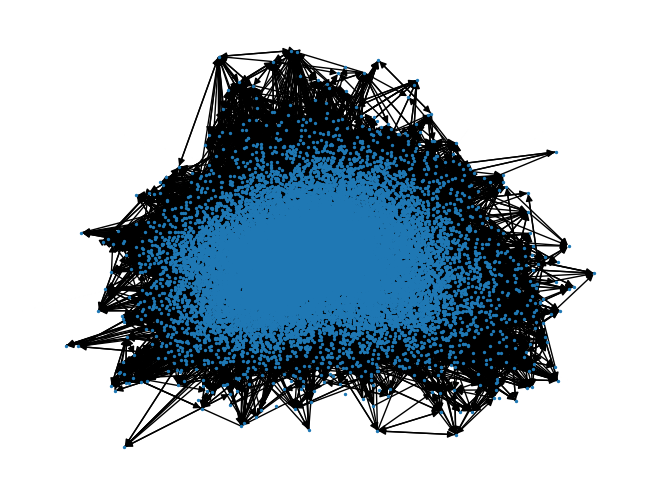

In [27]:
pos = dict(map(lambda v: (v[0], np.array(v[1]['coords']).tolist()), graph.nodes(data=True)))
nx.draw(graph, node_size=2, pos=pos)

Тут я решил посмотреть удаленные точки в пространстве (в разложенном уже), но скучные слова вышли

In [28]:
node_left, node_right = None, None
for node_id, node_props in graph.nodes(data=True):
    min_, max_ = node_props['coords']

    if node_left is None or min_ < node_left[2]:
        node_left = (node_id, min_, max_)

    if node_right is None or max_ > node_right[2]:
        node_right = (node_id, min_, max_)

node_left, node_right

(('дыхание_NOUN', -5.567465782165527, -15.33974552154541),
 ('отправлять_VERB', -2.784200668334961, 20.465377807617188))

## Это СТОК

In [29]:
graph['идиот_NOUN']

AtlasView({'кретин_NOUN': {'dist': 13.197740673566773}, 'дебил_NOUN': {'dist': 14.588011305607735}, 'дурак_NOUN': {'dist': 16.996126519015757}, 'кретина_NOUN': {'dist': 16.391369739991987}, 'идиотка_NOUN': {'dist': 15.733557459210095}, 'псих_NOUN': {'dist': 15.848939185037452}, 'тупица_NOUN': {'dist': 16.493477196730304}, 'придурок_NOUN': {'dist': 17.312949494954456}, 'болван_ADJ': {'dist': 17.18132079974727}, 'сумасшедший_NOUN': {'dist': 17.746122554593615}})

# Это ИСТОК

In [30]:
graph['кое-кто_NOUN']

AtlasView({'кой-кто_ADJ': {'dist': 16.2337631095586}, 'кое-кто_ADJ': {'dist': 16.905101010805787}, 'кто-нибудь_NOUN': {'dist': 21.848768451821904}, 'однокашник_NOUN': {'dist': 19.592890232333}, 'партиец_NOUN': {'dist': 20.663031637802902}, 'кое-что_NOUN': {'dist': 22.65692617525461}, 'ловкач_NOUN': {'dist': 17.703180163197374}, 'братва_NOUN': {'dist': 19.691464754550065}, 'функционер_NOUN': {'dist': 21.590094294163222}, 'стукач_NOUN': {'dist': 21.976463906195477}})

## Сохраняем в файл в формате списка смежности

In [31]:
nx.write_adjlist(graph, 'idiot_graph_adjlist.txt')

In [32]:
with open('adj_with_weights.txt', 'w', encoding='utf-8') as f:
    for node in graph:
        neighbors = []
        for neighbor in graph[node]:
            weight = graph[node][neighbor].get('dist', 1.0)
            neighbors.append(f"{neighbor}?{weight}")
        f.write(f"{node} {' '.join(neighbors)}\n")

In [33]:
!cp adj_with_weights.txt /content/drive/MyDrive/алгосы/

# А вот здесь вам придется дообучить модель.

Для этого самостоятельно нужно похожим образом разбить на предложения (самый простой вариант - линия - это предложение. Однако это не трушный путь). Далее обучаете модель, получаем новый граф, и для него снова считаете максимальный поток между таким же стоком и истоком

Пришла идея сгенерировать предложения через иначально рандомное слово, смотря его соседей.

In [34]:
def transition_probability(current_word, neighbor, previous_word, graph, p, q):
    weight = graph[current_word][neighbor]["dist"]
    if neighbor == previous_word:
        return 1 / (p * weight)
    elif neighbor in graph[current_word]:
        return 1 / (q * weight)
    else:
        return 0

Обходя грав через через кластеризацию Алгоритмом Лувена

In [35]:
!pip install python-louvain

In [36]:
import community as community_louvain
import random

In [37]:
def get_clusters(graph):
    return community_louvain.best_partition(graph,resolution = 1.5)

In [38]:
def generate_sentence_by_cluster(graph, start_word, length, clusters, p=1, q=1):
    sentence = [start_word]
    current_word = start_word
    previous_word = None
    current_cluster = clusters[start_word]

    while len(sentence) < length:
        neighbors = list(graph[current_word].keys())
        if not neighbors:
            break

        probabilities = [
            transition_probability(current_word, n, previous_word, graph, p, q)
            for n in neighbors
        ]
        total_prob = sum(probabilities)
        if total_prob == 0:
            break

        normalized_probs = [prob / total_prob for prob in probabilities]
        next_word = random.choices(neighbors, weights=normalized_probs)[0]

        if clusters[next_word] != current_cluster:
            break

        sentence.append(next_word)
        previous_word = current_word
        current_word = next_word

    return sentence

In [39]:
def generate_clustered_sentences(graph, num_sentences, length, p=1, q=1):
    undirected_graph = graph.to_undirected()
    clusters = get_clusters(undirected_graph)
    sentences = []
    correct = 0

    while correct < num_sentences:
        start_words = random.choices(list(graph.nodes()), k=num_sentences - correct)
        for word in start_words:
            sentence = generate_sentence_by_cluster(graph, word, length, clusters, p, q)
            if len(sentence) > length / 2:
                sentences.append(sentence)
                correct += 1
                if correct % 1000 == 0:
                    print(f"{correct} / {num_sentences}")

    return sentences

In [40]:
undirected_graph = graph.to_undirected()
clusters = get_clusters(undirected_graph)

In [41]:
clustered_sentences = generate_clustered_sentences(graph, 1205000, 15, p=1, q=1)

1000 / 1205000
2000 / 1205000
3000 / 1205000
4000 / 1205000
5000 / 1205000
6000 / 1205000
7000 / 1205000
8000 / 1205000
9000 / 1205000
10000 / 1205000
11000 / 1205000
12000 / 1205000
13000 / 1205000
14000 / 1205000
15000 / 1205000
16000 / 1205000
17000 / 1205000
18000 / 1205000
19000 / 1205000
20000 / 1205000
21000 / 1205000
22000 / 1205000
23000 / 1205000
24000 / 1205000
25000 / 1205000
26000 / 1205000
27000 / 1205000
28000 / 1205000
29000 / 1205000
30000 / 1205000
31000 / 1205000
32000 / 1205000
33000 / 1205000
34000 / 1205000
35000 / 1205000
36000 / 1205000
37000 / 1205000
38000 / 1205000
39000 / 1205000
40000 / 1205000
41000 / 1205000
42000 / 1205000
43000 / 1205000
44000 / 1205000
45000 / 1205000
46000 / 1205000
47000 / 1205000
48000 / 1205000
49000 / 1205000
50000 / 1205000
51000 / 1205000
52000 / 1205000
53000 / 1205000
54000 / 1205000
55000 / 1205000
56000 / 1205000
57000 / 1205000
58000 / 1205000
59000 / 1205000
60000 / 1205000
61000 / 1205000
62000 / 1205000
63000 / 1205000
6

In [42]:
clustered_sentences

[['взглянуть_VERB',
  'глянуть_VERB',
  'поглядеть_VERB',
  'оглядывать_VERB',
  'оглядеть_NOUN',
  'оглядеть_VERB',
  'глянуть_VERB',
  'покоситься_VERB',
  'уставиться_VERB',
  'зыркнуть_VERB'],
 ['грезить_VERB',
  'мечтаться_VERB',
  'мечта_NOUN',
  'мечтать_VERB',
  'грезить_VERB',
  'сниться_VERB',
  'грезиться_VERB',
  'привидеться_VERB'],
 ['кстати_ADV',
  'правда_ADV',
  'впрочем_ADV',
  'правда_ADV',
  'конечно_ADV',
  'впрочем_ADV',
  'вероятно_ADV',
  'по-видимому_ADV',
  'очевидно_ADV',
  'видимо_ADV'],
 ['однако_ADV',
  'разумеется_ADV',
  'впрочем_ADV',
  'конечно_ADV',
  'разумеется_ADV',
  'опять-таки_ADV',
  'конечно_ADV',
  'разумеется_ADV',
  'притом_ADV',
  'потому_ADV',
  'притом_ADV',
  'впрочем_ADV',
  'вовсе_ADV',
  'конечно_ADV',
  'правда_ADV'],
 ['смотреть_VERB',
  'глядеть_VERB',
  'смотреть_VERB',
  'поглядывать_VERB',
  'посматривать_VERB',
  'коситься_VERB',
  'глядеть_VERB',
  'разглядывать_VERB',
  'посматривать_VERB',
  'разглядывать_VERB',
  'всматрив

False


In [45]:
new_model = gensim.models.Word2Vec(clustered_sentences, min_count=1, vector_size=100, window=5, workers=4).wv

Почему-то изначально не было пути между истоком и истоком в изначальном графе, пофиксилось увелечением максимальной дистанции, а потом вообще не находило исток в модельке, пофиксилось увелечением размерности кластера

In [58]:
print('кое-кто_NOUN' in graph.nodes())
print(list(graph.neighbors('кое-кто_NOUN')))
count = sum(sentence.count('кое-кто_NOUN') for sentence in clustered_sentences)
print(count)

True
['кой-кто_ADJ', 'кое-кто_ADJ', 'кто-нибудь_NOUN', 'однокашник_NOUN', 'партиец_NOUN', 'кое-что_NOUN', 'ловкач_NOUN', 'братва_NOUN', 'функционер_NOUN', 'стукач_NOUN']
140


In [65]:
print('кое-кто_NOUN' for sentence in clustered_sentences)

<generator object <genexpr> at 0x7a78c2502670>


In [66]:
print('идиот_NOUN' for sentence in clustered_sentences)

<generator object <genexpr> at 0x7a78ba1f8520>


Честно лучше б траву трогал чем занимался вот этой проверкой

In [67]:
new_word = ['кое-кто_NOUN', 'идиот_NOUN']

for word in new_word:
    # есть ли слово в модели? Может быть, и нет
    if word in new_model:
        print(word)
        # выдаем 10 ближайших соседей слова:
        for i in model.most_similar(positive=[word], topn=5):
            # слово + коэффициент косинусной близости
            print(i[0], round(i[1], 2), end=' ')
        print('\n')
    else:
        # Увы!
        print(word + ' is not present in the model')

кое-кто_NOUN
кой-кто_ADJ 0.48 кое-кто_ADJ 0.42 кто-нибудь_NOUN 0.42 однокашник_NOUN 0.41 партиец_NOUN 0.41 

идиот_NOUN
кретин_NOUN 0.75 дебил_NOUN 0.68 дурак_NOUN 0.66 кретина_NOUN 0.65 идиотка_NOUN 0.62 



In [48]:
new_graph = create_graph(new_model, data_input, 10, limit_nodes=None, max_distance=30)

500 91722
1000 91722
1500 91722
2000 91722
2500 91722
3000 91722
3500 91722
4000 91722
4500 91722
5000 91722
5500 91722
6000 91722
6500 91722
7000 91722
7500 91722
8000 91722
8500 91722
9000 91722
9500 91722
10000 91722
10500 91722
11000 91722
11500 91722
12000 91722
12500 91722
13000 91722
13500 91722
14000 91722
14500 91722
15000 91722
15500 91722
16000 91722
16500 91722
17000 91722
17500 91722
18000 91722
18500 91722
19000 91722
19500 91722
20000 91722
20500 91722
21000 91722
21500 91722
22000 91722
22500 91722
23000 91722
23500 91722
24000 91722
24500 91722
25000 91722
25500 91722
26000 91722
26500 91722
27000 91722
27500 91722
28000 91722
28500 91722
29000 91722
29500 91722
30000 91722
30500 91722
31000 91722
31500 91722
32000 91722
32500 91722
33000 91722
33500 91722
34000 91722
34500 91722
35000 91722
35500 91722
36000 91722
36500 91722
37000 91722
37500 91722
38000 91722
38500 91722
39000 91722
39500 91722
40000 91722
40500 91722
41000 91722
41500 91722
42000 91722
42500 91722


Запиши новый список смежности

In [49]:
with open('adj2_with_weights.txt', 'w', encoding='utf-8') as f:
    for node in new_graph:
        neighbors = []
        for neighbor in new_graph[node]:
            weight = new_graph[node][neighbor].get('dist', 1.0)
            neighbors.append(f"{neighbor}?{weight}")
        f.write(f"{node} {' '.join(neighbors)}\n")

In [50]:
!cp adj2_with_weights.txt /content/drive/MyDrive/алгосы/

Эт тоже для дебага


In [59]:
print("кое-кто_NOUN" in graph)
print("идиот_NOUN" in graph)

print("кое-кто_NOUN" in new_graph)
print("идиот_NOUN" in new_graph)

True
True
True
True
